In this file we are going to experiment the multi-shot-prompting, ny giving the model a bunch of prompts.

Using OpenAI API key successfully from the environment.


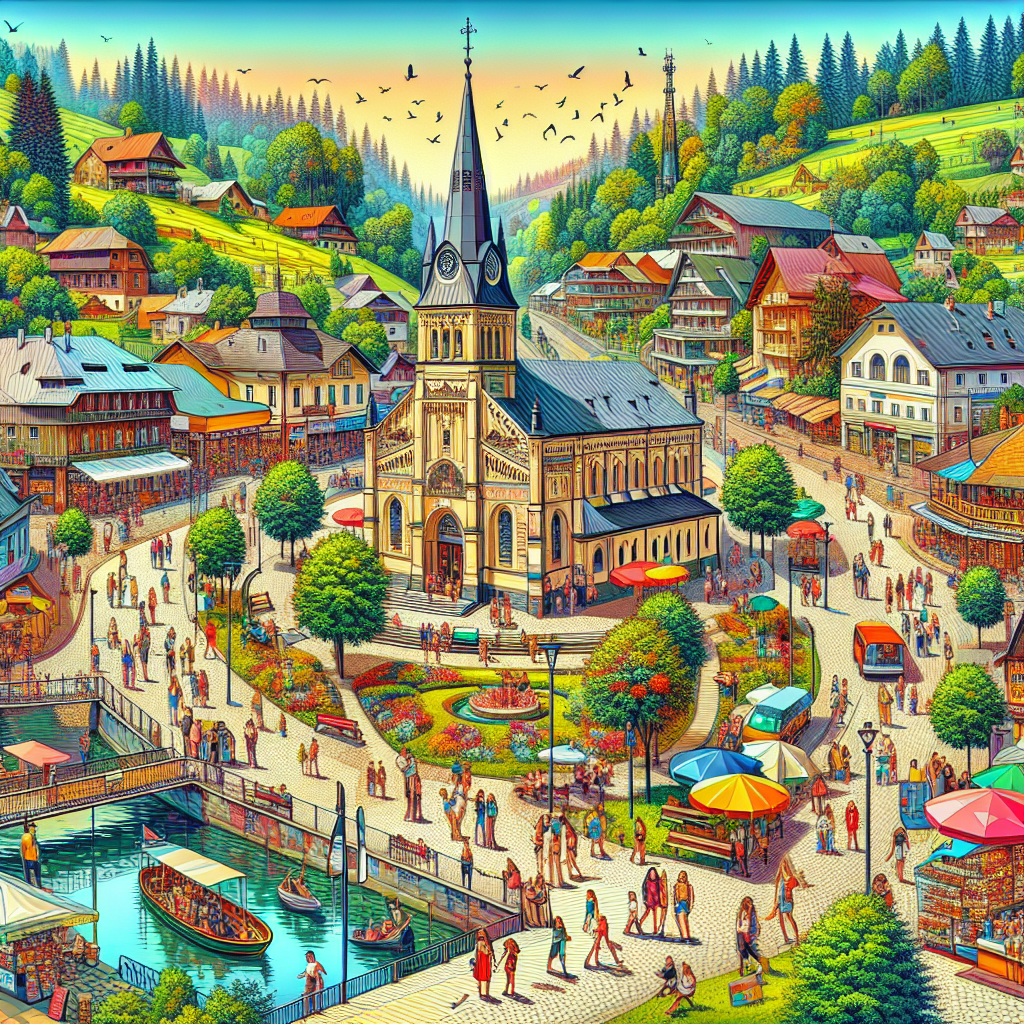

In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import json
import base64
from io import BytesIO
from PIL import Image


# Load environment variables from .env file
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

if openai_api_key is not None and openai_api_key.startswith("sk-proj"):
    print("Using OpenAI API key successfully from the environment.")
else:
    print("Cannot find any valid OpenAI API keys in your environment.")

openai = OpenAI()
MODEL = "gpt-4o-mini"

# system_message = "You are a helpful assistant."


# Function to handle chat messages
def chat(message, history):
    messages = [{"role" : "system", "content" : system_message}] + history + [{"role" : "user", "content" : message}]

    stream = openai.chat.completions.create(
        model = MODEL,
        messages = messages,
        stream = True
    )

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ""
        yield response

force_dark_mode = """
function refresh() {
    const url = new URL(window.location);
    if (url.searchParams.get('__theme') !== 'dark') {
        url.searchParams.set('__theme', 'dark');
        window.location.href = url.href;
    }
}
"""

# gr.ChatInterface(fn = chat, js = force_dark_mode, type = "messages").launch(inbrowser = True)


system_message = "You are an helpful assistant for an Airline called Frontier Airlines."
system_message += "Provide short, courteous responses, which will not exceed 1 sentence per response."
system_message += "If you do not know the answer, simply say so."

# Function to handle the usage of tools for the frontier llm
def short_chat(message, history):
    messages = [{"role" : "system", "content" : system_message}] + history + [{"role" : "user", "content" : message}]

    response = openai.chat.completions.create(
        model = MODEL,
        messages = messages
    )

    return response.choices[0].message.content


ticket_prices = {"bucharest" : 400, "paris" : 500, "london" : 600, "new york" : 700, "los angeles" : 800, "chicago" : 900}

system_message += f"You can give recommendations if you are asked so, but only about these destinations : {ticket_prices.keys()}."
system_message += "Always respond with calm and courtesy."

def get_ticket_price(destination):
    print(f"Fetching ticket price for {destination}")
    city = destination.lower()
    return ticket_prices.get(city, "Unknown destination")

# print(get_ticket_price("Bucharest"))

price_function = {
    "name" : "get_ticket_price",
    "description" : "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer is asking 'How much is a ticket to this city?'",
    "parameters" : {
        "type" : "object",
        "properties" : {
            "destination" : {
                "type" : "string",
                "description" : "The city that the customer wants to travel to.",
            },
        },
        "required" : ["destination"],
        "additionalProperties" : False,
    }
}

tools = [{"type" : "function", "function" : price_function}]

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city


def chat_with_tools(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

# gr.ChatInterface(fn = chat_with_tools, js = force_dark_mode, type = "messages").launch(inbrowser = True)


### image generation ### !!!!

def artist(city):
    image_response = openai.images.generate(
        model = "dall-e-3",
        prompt = f"An image representing a vacantion in {city}, showing tourists spots and everything unique about {city}, in a vibrant style.",
        size = "1024x1024",
        n = 1, ### number of images to generate
        response_format = "b64_json"
    )

    image_base64 = image_response.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_bytes))

image = artist("Dej")
display(image)




In [2]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1", # text-to-speech model
        voice="onyx", # voice for the model
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")